# Instrument recognition in musical audio signals
Group 2: Jakob Dittrich, Lea Franz, David Reiter, Thomas Sickinger

## Setup

In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from os import listdir
import librosa.display

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_score

%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# color for plots
pltcolor = '#002b36'
plt.rcParams['figure.figsize'] = [16, 9]

## Data

The training data contains 6705 audio files in 16 bit stereo wav format sampled at 44.1kHz. They are excerpts of 3 seconds from more than 2000 distinct recordings. The number of files per instrument are: cello (388), clarinet (505), flute (451), acoustic guitar (637), electric guitar (760), organ (682), piano (721), saxophone (626), trumpet (577), violin (580), human voice (778).


The test data contains 2874 excerpts in 16 bit stereo wav format sampled at 44.1kHz.

Source: https://www.upf.edu/web/mtg/irmas

### Loading the data
For loading the audio data we use **librosa**. This is python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.

## Analysis of data

## Class balance

The plot shows that the classes are not balanced. The class with the most samples is **vio** and the class with the least samples is **cel**.

In [2]:
class_dirs = os.listdir('./IRMAS-TrainingData/')
class_dirs.remove('.DS_Store')
class_dirs.remove('README.txt')
class_dirs

['pia', 'voi', 'tru', 'sax', 'org', 'cla', 'gac', 'vio', 'flu', 'gel', 'cel']

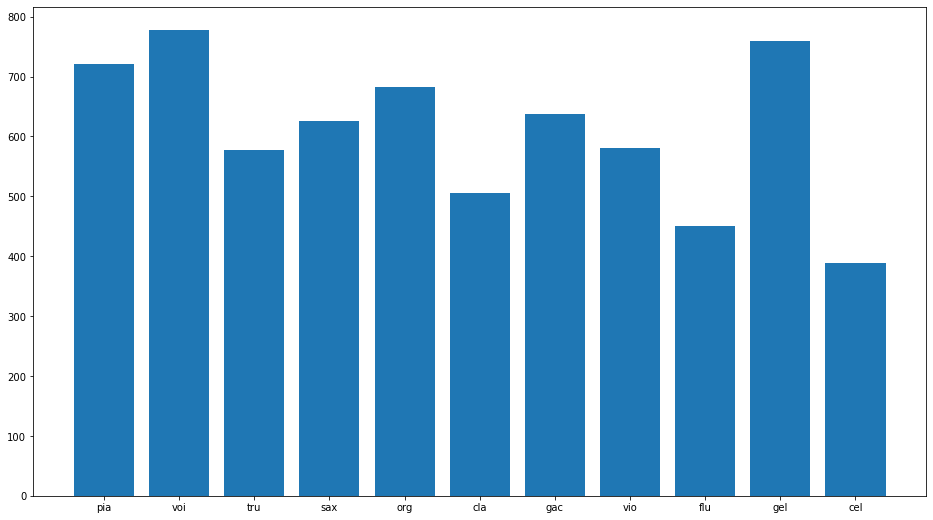

In [3]:
number_of_files = []
for class_name in class_dirs:
    class_dir = os.listdir('./IRMAS-TrainingData/'+class_name)
    number_of_files.append(len(class_dir))

number_of_files

plt.bar(class_dirs, number_of_files);

### Example file

In [4]:
y , sr = librosa.load('./IRMAS-TrainingData/cel/008__[cel][nod][cla]0058__1.wav')

Waveform in the time domain

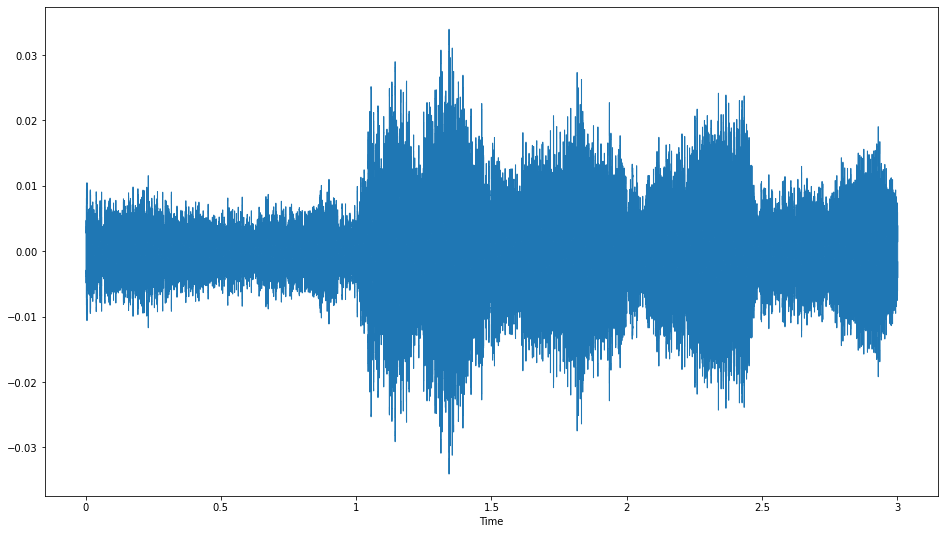

In [5]:
librosa.display.waveshow(y, sr=sr);

Spectrogram

A spectrogram is the visual representation of the spectrum of frequencies of a signal over time.

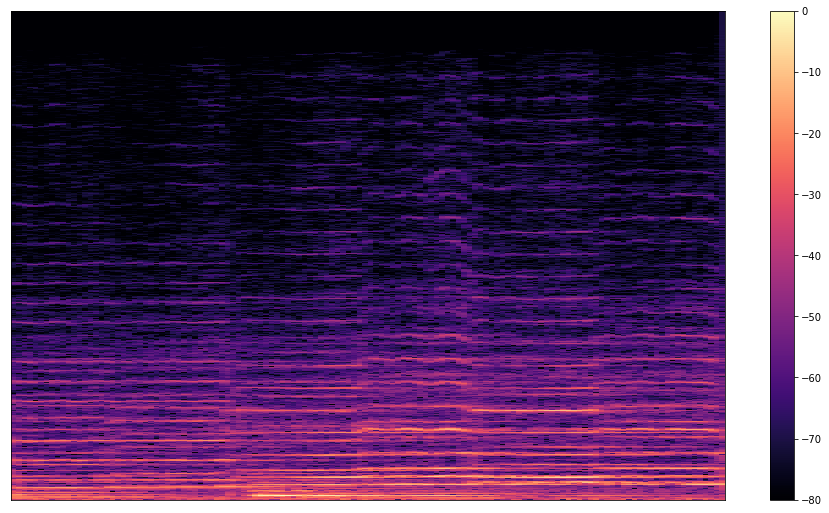

In [6]:
stft = librosa.stft(y)  # short time fourier transform
magnitudes_to_decibel = librosa.amplitude_to_db(np.abs(stft), ref=np.max) # mapping magnitudes to decibel scale

plt.figure()
librosa.display.specshow(magnitudes_to_decibel)
plt.colorbar();

## Feature extraction

Zero Crossing Rate: the rate at which the signal crosses zero
Spectral Centroid: the center of mass in the spectrum
Spectral Bandwidth: the weighted average of the frequency signal by its spectrum
Spectral Roll-Off: frequency below which a specified percentage of the total spectral energy

In [4]:
header = 'filename rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [7]:


file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)



In [13]:
Instruments = 'flu pia tru org gac voi'.split()
for i in Instruments:
    for filename in os.listdir(f'C:/Users/david/anaconda notebooks/Machine Learning/project/IRMAS-TrainingData/{i}'):
        songname = f'C:/Users/david/anaconda notebooks/Machine Learning/project/IRMAS-TrainingData/{i}/{filename}'
        y, sr = librosa.load(songname, sr =44100)
        rms = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {i}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [14]:
df = pd.read_csv('data.csv')
df.head()


,filename,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,008__[flu][nod][cla]0393__1.wav,0.041384,1324.199249,1918.867304,1637.105416,0.042741,-380.337616,194.652420,0.845311,-12.051190,...,-7.628513,4.840517,-6.557875,-9.930728,-16.661924,-9.294560,-2.751670,-2.165901,1.932015,flu
1,008__[flu][nod][cla]0393__2.wav,0.038483,1123.974170,1591.315078,1609.336729,0.033182,-392.331512,214.486053,-7.058401,-12.224262,...,-9.103989,-4.731387,-13.547755,-9.173700,-11.763280,-2.906017,1.568288,0.220456,0.958660,flu
2,008__[flu][nod][cla]0393__3.wav,0.068834,1346.845745,1835.863034,1725.898701,0.048355,-326.475769,199.856110,-6.817063,-18.801710,...,-4.161035,4.904843,-12.327797,-13.420050,-13.455204,-1.928725,-0.520475,-3.958643,1.799282,flu
3,009__[flu][nod][cou_fol]0410__1.wav,0.110672,3731.857796,2916.063001,6536.033837,0.083345,-278.265625,34.690239,-115.731903,11.941927,...,-10.709307,21.715712,19.567368,2.223477,-0.893254,-6.435685,-7.909177,-0.824891,5.366472,flu
4,009__[flu][nod][cou_fol]0410__2.wav,0.135578,3564.364963,2857.784457,6234.319573,0.082947,-271.554169,38.720463,-108.625481,5.935997,...,-0.944184,17.835960,6.320951,-5.579783,1.722641,1.136189,-4.124919,-1.088647,4.311995,flu


In [16]:
print(df.shape)
# extract features without filename
features = df[df.columns[2:26]]

(3846, 27)


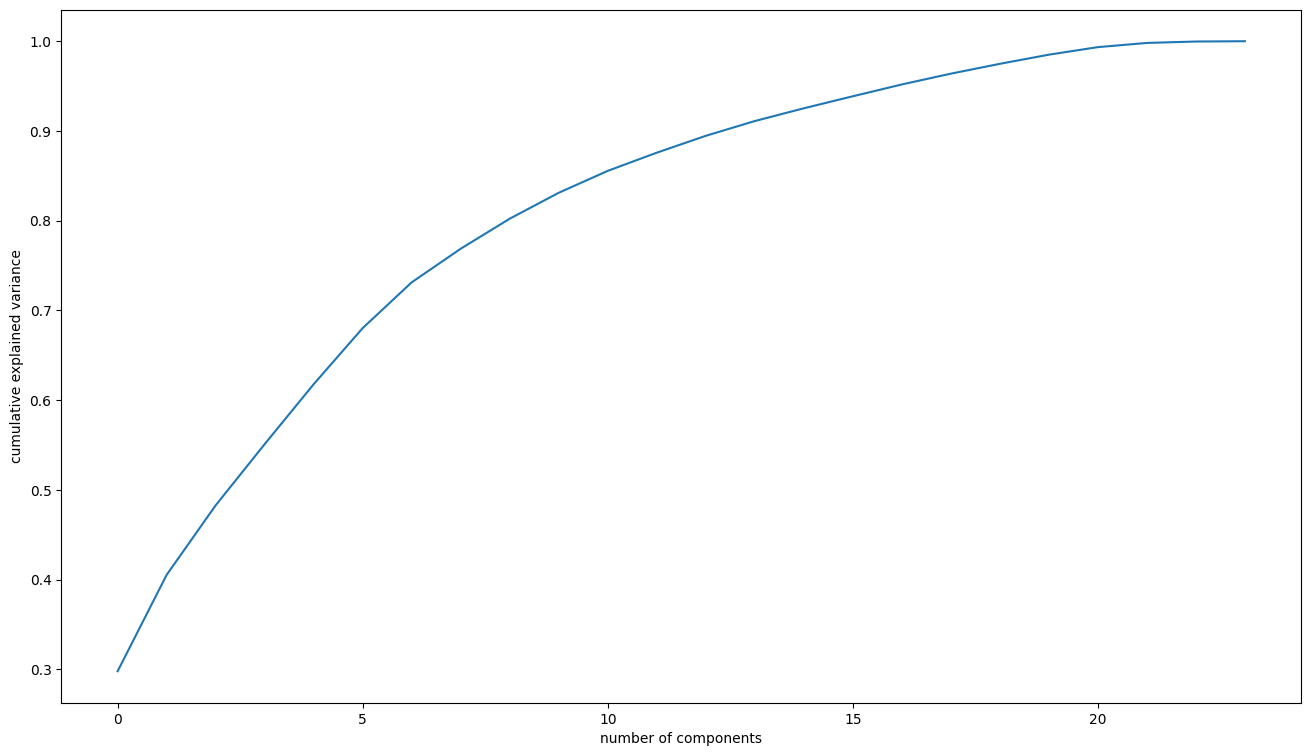

In [19]:
X = scale(features)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()



In [20]:
# drop filename from dataframe
df = df.drop(['filename'],axis=1)

In [22]:
# shuffle dataframe
df1 = shuffle(df)
df1.head()



,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
3702,0.063341,1887.641356,2920.792588,3879.052734,0.034315,-282.627960,178.439850,24.932907,21.310320,-12.475399,...,-5.823398,-8.288774,0.825588,-0.305034,-5.560237,-5.206818,3.530899,-0.769603,-5.549954,voi
3287,0.104930,2242.317352,2513.742100,4361.928579,0.057119,-170.324844,179.306793,-52.540520,44.115475,-13.910841,...,-1.932448,-2.357487,-7.685655,-0.765182,-7.043972,-2.488256,-5.746339,0.585556,-4.481190,voi
2645,0.021514,663.591443,1152.650533,1028.272804,0.016336,-494.106842,222.459778,61.070747,7.143574,1.491584,...,-5.585597,-2.452932,-5.662074,-8.649795,-8.616337,-9.249663,-8.799469,-4.283798,-0.209346,gac
2637,0.051519,962.290350,1337.995059,1667.451436,0.022333,-370.837463,190.028702,6.821610,3.572097,11.671145,...,-15.666713,-9.687362,-3.046289,-0.832102,-6.110205,-13.155462,-7.952098,-0.963191,1.673959,gac
2596,0.032185,1226.595403,1488.882290,2099.362595,0.032228,-401.165253,188.462204,-15.226898,1.994516,-0.767508,...,-11.657848,-3.875262,-4.512492,-4.452294,2.190393,6.080932,3.124646,-0.872379,-2.088057,gac


In [27]:
# extract instrument labels
instru_list = df1.iloc[:, -1]
encoder = LabelEncoder()

# encode labels to numeric values
y = encoder.fit_transform(instru_list)

# uniformly scale data
scaler = StandardScaler()
X = scaler.fit_transform(np.array(df1.iloc[:, :-1], dtype = float))

In [25]:
# print labels
print(y)

[5 5 1 ... 5 3 5]


In [26]:
# split dataset in train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### SVM Model

In [29]:
# create SVM kernel
svclassifier = SVC(kernel='rbf', C = 10.0, gamma=0.1)

# fit data
svclassifier.fit(X_train, y_train);

In [32]:
# Calculate the accuracy score and predict target values
score = svclassifier.score(X_train, y_train)
print("Test score: {0:.2f} %".format(100 * score))



Test score: 99.93 %


Recall:  [0.62790698 0.825      0.77922078 0.74496644 0.75       0.82165605]
Precision:  [0.6835443  0.76153846 0.74074074 0.81021898 0.75728155 0.81132075]
F1-Score:  [0.65454545 0.792      0.75949367 0.77622378 0.75362319 0.8164557 ]
Accuracy: 0.77  , 591
Number of samples: 770


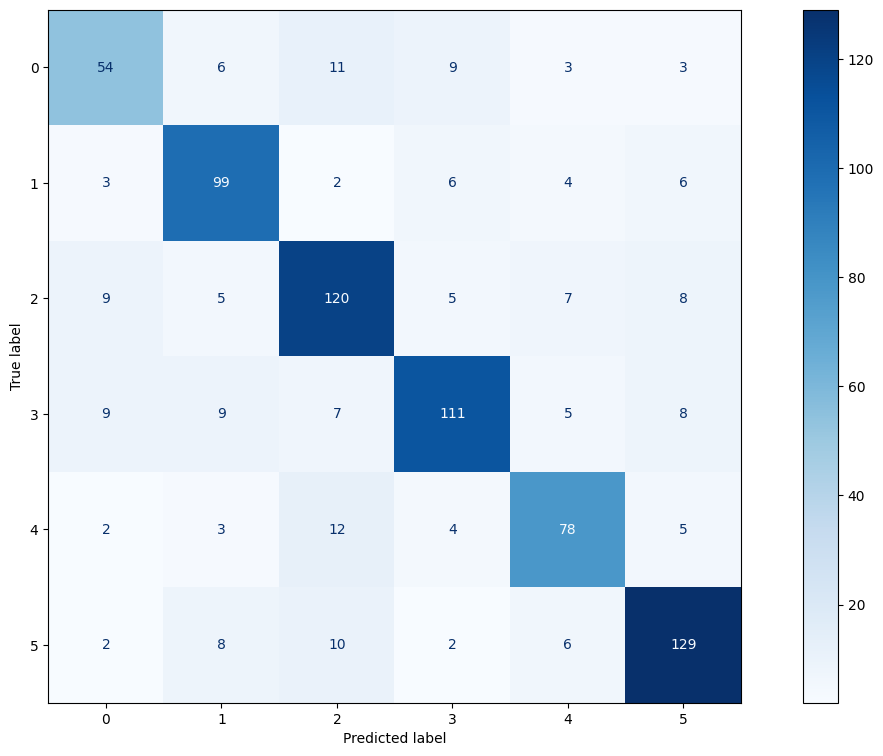

In [36]:
predicted_labels = svclassifier.predict(X_test)

print("Recall: ", recall_score(y_test, predicted_labels,average=None))
print("Precision: ", precision_score(y_test, predicted_labels,average=None))
print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,normalize=True), accuracy_score(y_test, predicted_labels,normalize=False) )

print("Number of samples:",y_test.shape[0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_labels), display_labels=Instruments).plot(cmap="Blues");
